# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
import pandas as pd

## Load the data into a DataFrame
df = pd.read_csv('assets/Iowa_Liquor_sales_sample_10pct.csv')

**Transform and clean data**
- rename columns
- adjust formats (date to datetime format, strings to numbers, etc.)
- drop nan values
- convert money columns from string to float

In [3]:
 #remove blank spaces and capitals from column headers
df.columns = [x.lower().replace(' ','_').replace('(', '').replace(')', '') for x in df.columns]

# time into a datetime format
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

# drop the rows with bad zip code data
df = df.drop(df[df.zip_code == '712-2'].index)

# drop rows that are annoying us with NaN values
df.dropna(inplace=True)  

# convert from string to number
df['store_number'] = df['store_number'].astype('int')  

# convert from string to number
df['zip_code'] = df['zip_code'].astype('int') 

In [4]:
# strip dollar sign and convert money values from string to float
def convert_money(x):
    x = x.strip('$')
    return float(x)

df['sale_dollars'] = df['sale_dollars'].apply(convert_money)
df['state_bottle_cost'] = df['state_bottle_cost'].apply(convert_money)
df['state_bottle_retail'] = df['state_bottle_retail'].apply(convert_money)

In [5]:
df.head(3)

,date,store_number,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34


**Standardize all the data we want to graph, into another dataframe**

In [6]:
from sklearn.preprocessing import StandardScaler
df_graph = df.sample(frac=0.001)   # create a small copy to standardize

cont_feats = ['bottle_volume_ml', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold', 'sale_dollars']
df_graph[cont_feats] = StandardScaler().fit_transform(df_graph[cont_feats])

In [8]:
df_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 169773 to 21538
Data columns (total 18 columns):
date                   269 non-null datetime64[ns]
store_number           269 non-null int64
city                   269 non-null object
zip_code               269 non-null int64
county_number          269 non-null float64
county                 269 non-null object
category               269 non-null float64
category_name          269 non-null object
vendor_number          269 non-null int64
item_number            269 non-null int64
item_description       269 non-null object
bottle_volume_ml       269 non-null float64
state_bottle_cost      269 non-null float64
state_bottle_retail    269 non-null float64
bottles_sold           269 non-null float64
sale_dollars           269 non-null float64
volume_sold_liters     269 non-null float64
volume_sold_gallons    269 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(4), object(4)
memory usage: 39.9+ KB


In [10]:
df_graph.head(3)

,date,store_number,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
169773,2016-01-26,2607,SHENANDOAH,51601,73.0,Page,1032080.0,IMPORTED VODKA,35,34359,Grey Goose Vodka,-1.453842,5.00,7.50,-0.445405,-0.450038,-0.606945,-0.606433
197886,2015-03-31,4355,STORY CITY,50248,85.0,Story,1081390.0,IMPORTED SCHNAPPS,260,69945,Rumple Minze Peppermint Schnapps Liqueur,-1.111601,7.13,10.70,-0.445405,-0.405548,-0.566439,-0.565151
31800,2015-09-22,4810,ANKENY,50021,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37338,UV Vodka PET,1.577434,10.99,16.49,0.174322,0.362736,0.982138,0.982941


**Do some quick and dirty visualization comparisons**

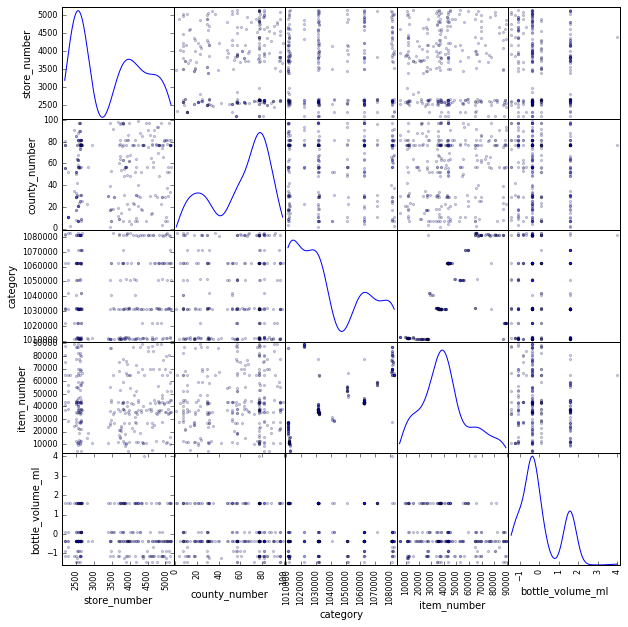

In [11]:
# an excellent way to start analysis - get an overview with scatter matrix
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

a=scatter_matrix(df_graph[['store_number', 'county_number', 'category', 'item_number', \
                          'bottle_volume_ml']], alpha=0.2, figsize=(10, 10), diagonal='kde')

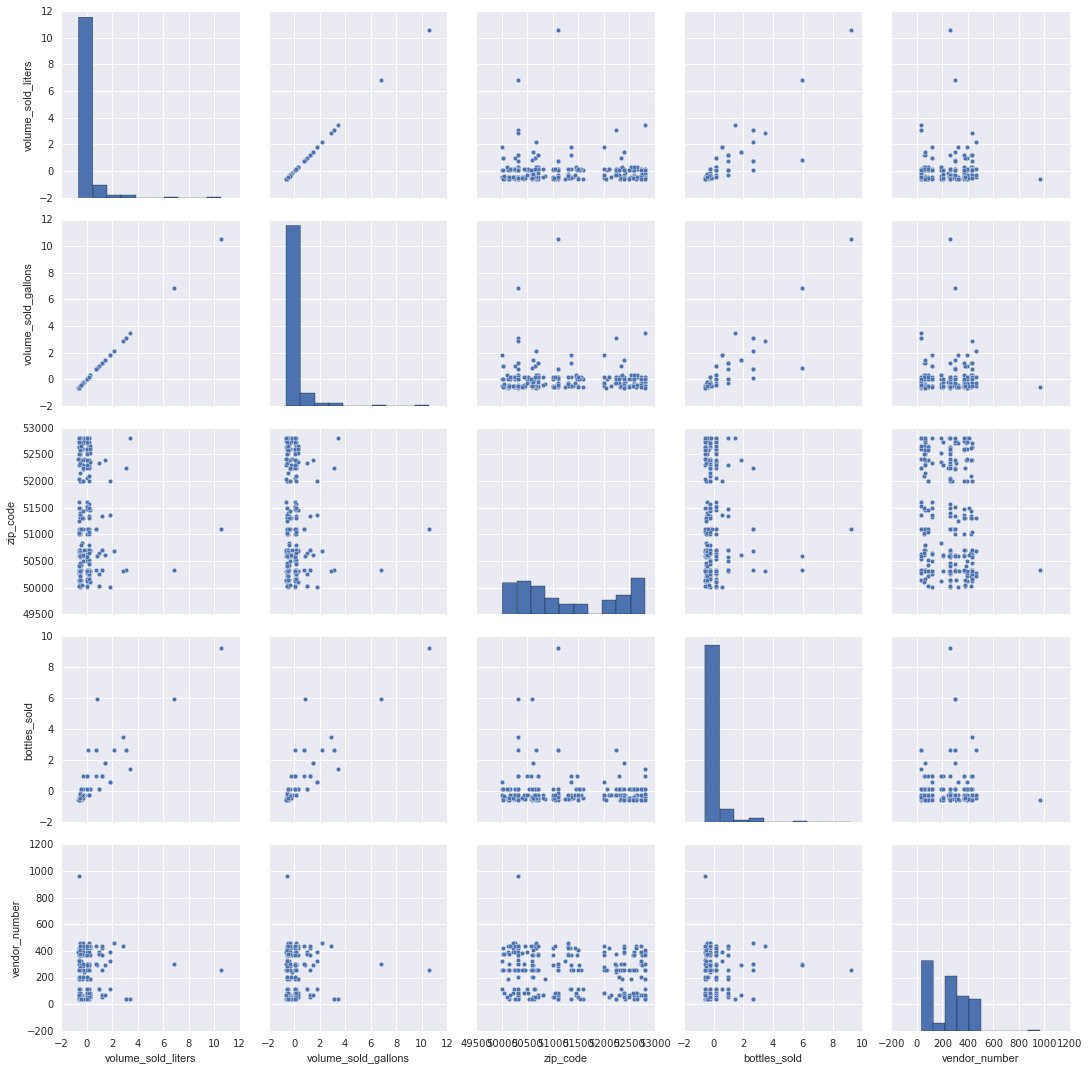

In [13]:
import seaborn as sb
sb.pairplot(df_graph[['volume_sold_liters', 'volume_sold_gallons', \
                          'zip_code','bottles_sold','vendor_number']],size=3)

**Conclusions from graphing**  
In general it doesn't appear that as represented strictly in the dataframe, that any meaningful data is correlated (though obviously further mixing and matching of features could be attempted).

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

#### Calculate the yearly liquor sales for each store

In [27]:
# create dataframes for each year
d_2015 = df[df['date'].dt.year == 2015].copy()
d_2016 = df[df['date'].dt.year == 2016].copy()

In [42]:
d_2015.groupby(['store_number', 'city'])['sale_dollars'].sum()

store_number  city           
2106          CEDAR FALLS        146038.70
2113          GOWRIE               9310.22
2130          WATERLOO           111583.91
2152          ROCKWELL             7721.08
2178          WAUKON              24324.18
2190          DES MOINES         121689.06
2191          KEOKUK             125093.49
2200          SAC CITY            22811.55
2205          CLARINDA            24623.01
2228          WINTERSET           17462.07
2233          SPIRIT LAKE         29553.34
2238          ALTOONA             11762.56
2248          DES MOINES          67682.06
2285          IOWA CITY           76927.11
2290          STORM LAKE          56289.66
2327          CORNING             10245.14
2353          CRESCO              53349.19
2367          SHENANDOAH           5010.83
2413          DUBUQUE             90065.02
2445          OAKLAND              7189.48
2448          INDIANOLA           17740.70
2459          GUTHRIE CENTER       7352.33
2460          HAMPTON   

In [41]:
d_2016.groupby(['store_number', 'city'])['sale_dollars'].sum()

store_number  city           
2106          CEDAR FALLS        30478.75
2113          GOWRIE              2065.90
2130          WATERLOO           27856.11
2152          ROCKWELL             904.66
2178          WAUKON              5588.50
2190          DES MOINES         31803.06
2191          KEOKUK             47338.20
2200          SAC CITY            4174.87
2228          WINTERSET           3086.38
2233          SPIRIT LAKE         6522.65
2238          ALTOONA              409.32
2248          DES MOINES         13998.44
2285          IOWA CITY          12238.81
2290          STORM LAKE         12448.07
2327          CORNING             2196.57
2353          CRESCO              2549.94
2413          DUBUQUE            22925.67
2445          OAKLAND             1423.37
2448          INDIANOLA           6738.18
2459          GUTHRIE CENTER      1803.90
2465          DUBUQUE             5269.80
2475          WEST BEND           4790.07
2478          ALTOONA             4462.62
2498

In [32]:
d_2015_Q1 = d_2015[(d_2015['date'].dt.month <= 3)].copy()

store_number  city           
2106          CEDAR FALLS        146038.70
2113          GOWRIE               9310.22
2130          WATERLOO           111583.91
2152          ROCKWELL             7721.08
2178          WAUKON              24324.18
2190          DES MOINES         121689.06
2191          KEOKUK             125093.49
2200          SAC CITY            22811.55
2205          CLARINDA            24623.01
2228          WINTERSET           17462.07
2233          SPIRIT LAKE         29553.34
2238          ALTOONA             11762.56
2248          DES MOINES          67682.06
2285          IOWA CITY           76927.11
2290          STORM LAKE          56289.66
2327          CORNING             10245.14
2353          CRESCO              53349.19
2367          SHENANDOAH           5010.83
2413          DUBUQUE             90065.02
2445          OAKLAND              7189.48
2448          INDIANOLA           17740.70
2459          GUTHRIE CENTER       7352.33
2460          HAMPTON   

In [38]:
s_2015.head()

,,sale_dollars
store_number,city,
2106,CEDAR FALLS,146038.70
2113,GOWRIE,9310.22
2130,WATERLOO,111583.91
2152,ROCKWELL,7721.08
2178,WAUKON,24324.18


In [ ]:
s2015_Q1 = pd.DataFrame(data=d_2015_Q1.groupby(['store_number', 'zip_code', 'county', 'city']) \
                       ['bottles_sold', 'volume_sold_liters', 'sale_dollars'].sum())

In [ ]:
s2015.reset_index(level=['store_number', 'zip_code', 'county', 'city'], inplace=True)
s2015_Q1.reset_index(level=['store_number', 'zip_code', 'county', 'city'], inplace=True)


In [ ]:
s2015.rename(columns={'sale_dollars': 'year_sales'}, inplace=True)
s2015_Q1.rename(columns={'sale_dollars': '1st_quarter_sales'}, inplace=True)

In [ ]:
s2015.insert(6, 'Q1_sales',  s2015_Q1['1st_quarter_sales'])

In [ ]:
s2015['average_btl_price'] = s2015['year_sales'] / s2015['bottles_sold']

In [ ]:
s2015.head(1)

In [ ]:
# same for 2016 (data only contains Q1 results)
d_2016 = df[df['date'].dt.year == 2016]
s2016 = pd.DataFrame(data=d_2016.groupby(['store_number', 'zip_code', 'county', 'city']) \
                       ['bottles_sold', 'volume_sold_liters', 'sale_dollars'].sum())
s2016.reset_index(level=['store_number', 'zip_code', 'county', 'city'], inplace=True)
s2016.rename(columns={'sale_dollars': 'Q1_sales'}, inplace=True)

In [ ]:
s2016['average_btl_price'] = s2016['Q1_sales'] / s2016['bottles_sold']

In [ ]:
s2016.head(1)

In [ ]:
%matplotlib inline
import numpy as np

xs = s2015.Q1_sales.values
ys = s2015.year_sales.values

def beta(xs, ys):
    numerator = 0.
    denominator = 0.
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    for x, y in zip(xs, ys):
        numerator += (x - x_mean) * (y - y_mean)
        denominator += (x - x_mean) * (x - x_mean)
    return numerator / denominator

def alpha(xs, ys):
    b = beta(xs, ys)
    a = np.mean(ys) - b * np.mean(xs)
    return a

# Plotting
from matplotlib import pyplot as plt

def predict(xs, ys):
    a = alpha(xs, ys)
    b = beta(xs, ys)
    yhats = [a + b * x for x in xs]
    return yhats

ps = predict(xs, ys)

# The raw data
plt.scatter(xs, ys)
# The best fit line
plt.plot(xs, ps)
plt.show()

#### Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. 
- You must use the sales from Jan to March per store as one of your variables.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [ ]:
est = smf.ols('year_sales ~ Q1_sales', s2015).fit()
est.summary()

In [ ]:
est = smf.ols('year_sales ~ average_btl_price', s2015).fit()
est.summary()

In [ ]:
from sklearn.cross_validation import KFold
import patsy
import statsmodels.api as sm

kf = KFold(len(s2015), n_folds=10)
kf

In [ ]:
for train_index, test_index in kf:
    train_data_df = s2015.iloc[train_index]
    y, X = patsy.dmatrices('year_sales ~ Q1_sales', data=train_data_df, return_type='dataframe')
    model = sm.OLS(y, X)
    results = model.fit()
    print results.summary()

In [ ]:
for train_index, test_index in kf:
    train_data_df = s2015.iloc[train_index]
    y, X = patsy.dmatrices('year_sales ~ average_btl_price', data=train_data_df, return_type='dataframe')
    model = sm.OLS(y, X)
    results = model.fit()
    print results.summary()

#### Conclusions
- The Q1 numbers were much better predictors than the average bottle price - no surprise there.
- I was surprised by the outliers on the Q1 predictors - there was one very low Adj.R(sq) score (0.008), and a high score (0.451). The rest all seemed clustered together in the high .2xx range.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.